Valores únicos disponíveis para a chave 'Sua relação com [nome gestor] é como:':
1. colega gestor
2. diretor
3. auto avaliação
4. liderado
Entrada inválida. Digite um número inteiro.
Os objetos filtrados foram salvos em 'resultados_Renato Freitas/rf_filtrado_diretor.json'
Total de objetos filtrados: 2
Competências disponíveis:
1. desenvolvimento de pessoas
2. trabalho em equipe
3. planejamento e organização
4. orientação para resultados
5. conhecimento técnico
6. otimização de recursos
Nenhuma competência selecionada. Por favor, escolha pelo menos uma competência.
Competências selecionadas: planejamento e organização, orientação para resultados, conhecimento técnico, otimização de recursos


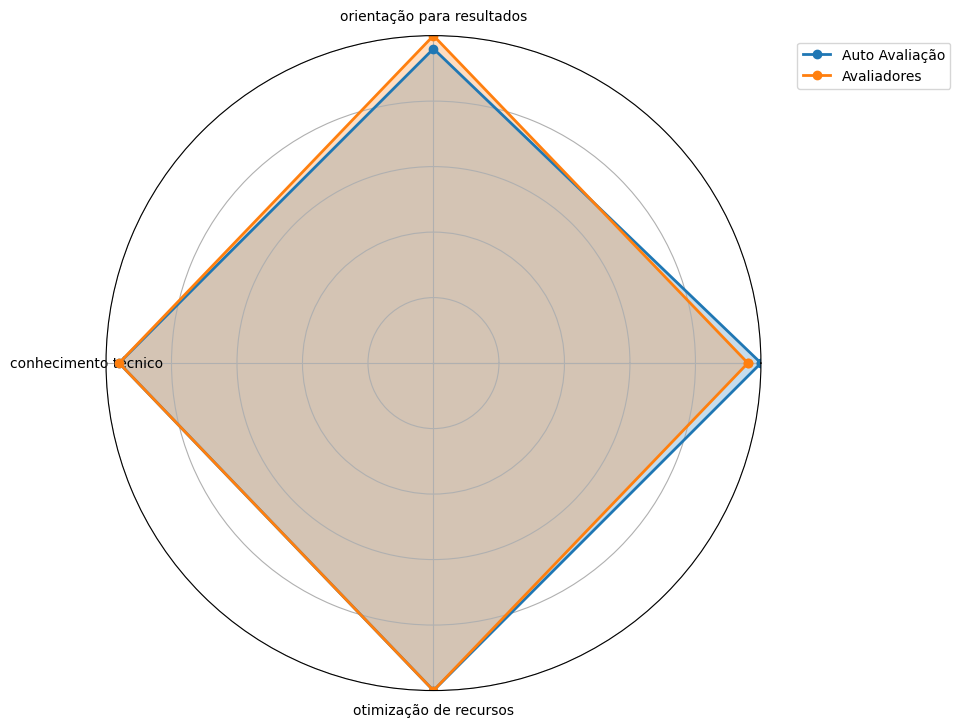

Encerrando o programa.


In [2]:
## programa que gera o JSON a partir do csv e entrega o heatmap pela competencia selecionada mais o arquivo JSON filtrado pela competencia

import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

# Constantes
RELACAO_CHAVE = "Sua relação com [nome gestor] é como:"
LABEL_AUTOAV = 'autoav'

def csv_to_json(input_filename: str, evaluated_person_name: str) -> None:
    """
    Convert a CSV file to a JSON file.

    Args:
    input_filename (str): The filename of the input CSV file.
    evaluated_person_name (str): The name of the evaluated person.

    Returns:
    None
    """
    input_file = f"{input_filename}.csv"
    output_file = f"{input_filename}.json"

    try:
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(input_file)

        # Replace the first column with the evaluated person's name
        df.iloc[:, 0] = evaluated_person_name
        df.rename(columns={df.columns[0]: 'avaliado'}, inplace=True)

        # Define the columns to drop
        cols_to_drop = ['Response Type', 'Start Date (UTC)', 'Stage Date (UTC)', 'Submit Date (UTC)', 'Network ID', 'Tags']

        # Drop the specified columns
        df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

        # Replace empty cells with NaN
        df.replace('', pd.NA, inplace=True)

        # Convert the DataFrame to JSON
        df.to_json(output_file, orient='records', indent=4)

    except FileNotFoundError:
        print(f"Error: The file {input_file} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

def carregar_dados(json_path):
    try:
        with open(json_path, 'r', encoding='utf-8') as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"O arquivo '{json_path}' não foi encontrado.")
    except json.JSONDecodeError:
        print(f"O arquivo '{json_path}' não contém JSON válido.")
    return None

def extrair_valores_unicos(dados, chave):
    return {objeto[chave] for objeto in dados if chave in objeto and objeto[chave] is not None}

def salvar_objetos_filtrados(dados, novo_json_path):
    try:
        os.makedirs(os.path.dirname(novo_json_path), exist_ok=True)
        with open(novo_json_path, 'w', encoding='utf-8') as file:
            json.dump(dados, file, indent=4, ensure_ascii=False)
    except IOError:
        print(f"Erro ao salvar o arquivo '{novo_json_path}'.")

def filtrar_objetos(dados, chave, valor_escolhido):
    return [objeto for objeto in dados if objeto.get(chave) == valor_escolhido]

def carregar_perguntas(csv_path):
    try:
        return pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"O arquivo '{csv_path}' não foi encontrado.")
    except pd.errors.EmptyDataError:
        print(f"O arquivo '{csv_path}' está vazio.")
    return pd.DataFrame()

def escolher_competencias(perguntas_df):
    competencias = perguntas_df['Competencia'].unique()
    if not competencias.size:
        print("Nenhuma competência encontrada. Verifique o arquivo de perguntas.")
        return []

    print("Competências disponíveis:")
    for i, comp in enumerate(competencias, 1):
        print(f"{i}. {comp}")

    escolhas = []
    while True:
        escolha = input("Escolha uma ou mais competências pelos números, separados por vírgula (ou pressione Enter para finalizar): ")
        if escolha == "":
            if escolhas:
                break
            else:
                print("Nenhuma competência selecionada. Por favor, escolha pelo menos uma competência.")
                continue
        try:
            numeros = [int(n.strip()) for n in escolha.split(",")]
            numeros_validos = [n for n in numeros if 1 <= n <= len(competencias)]
            if not numeros_validos:
                print("Nenhum número válido fornecido. Por favor, escolha pelos menos uma competência válida.")
                continue
            for n in numeros_validos:
                if competencias[n - 1] not in escolhas:
                    escolhas.append(competencias[n - 1])
            print(f"Competências selecionadas: {', '.join(escolhas)}")
            break
        except ValueError:
            print("Entrada inválida. Digite números inteiros separados por vírgula.")

    return escolhas

def filtrar_perguntas_por_competencia(perguntas_df, competencia):
    return perguntas_df[perguntas_df['Competencia'] == competencia]

def filtrar_perguntas_numericas(perguntas_df):
    return perguntas_df[perguntas_df['Tipo'] == 'Numerica']['Pergunta'].tolist()

def converter_para_dataframe(dados, perguntas_iniciais, json_path_completo):
    perguntas = list(perguntas_iniciais)
    data = []
    index = []
    for avaliador in dados:
        respostas = [float(avaliador.get(pergunta)) if avaliador.get(pergunta) is not None else float('nan') for pergunta in perguntas]
        data.append(respostas)
        index.append(avaliador.get(RELACAO_CHAVE, 'Avaliador'))

    autoavaliacoes = carregar_dados(json_path_completo)
    if autoavaliacoes is None:
        return pd.DataFrame()

    autoavaliacao_respostas = [float('nan')] * len(perguntas)
    for avaliacao in autoavaliacoes:
        if avaliacao.get(RELACAO_CHAVE) == 'auto avaliação':
            for i, pergunta in enumerate(perguntas):
                valor = avaliacao.get(pergunta)
                if isinstance(valor, (int, float)):
                    autoavaliacao_respostas[i] = float(valor)

    if not all(math.isnan(x) for x in autoavaliacao_respostas):
        data.append(autoavaliacao_respostas)
        index.append(LABEL_AUTOAV)

    max_len = max(len(row) for row in data)
    data = [row + [float('nan')] * (max_len - len(row)) for row in data]

    return pd.DataFrame(data, columns=[f'Pergunta {i+1}' for i in range(max_len)], index=index)

def gerar_heatmap(df, titulo, imagem_path):
    if df.empty or df.dropna(how='all', axis=1).empty:
        print("Não há dados suficientes para gerar um heatmap.")
        return
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True, cmap="coolwarm_r", fmt=".1f", linewidths=.5, vmin=1, vmax=5, cbar_kws={"ticks": range(1, 6)})
    plt.title(titulo)
    plt.xlabel('Perguntas')
    plt.ylabel('Avaliadores')
    plt.tight_layout()
    plt.savefig(imagem_path)  # Salvar o heatmap como imagem
    plt.show()

def salvar_dataframe_como_json(df, json_path):
    try:
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        df.to_json(json_path, orient='records', indent=4)
        print(f"DataFrame salvo com sucesso em '{json_path}'")
    except IOError:
        print(f"Erro ao salvar o DataFrame em '{json_path}'")

def calcular_medias(dados_filtrados, perguntas_df, competencias_escolhidas, json_path):
    medias_autoavaliacao = []
    medias_avaliadores = []

    dados_completos = carregar_dados(json_path)
    if dados_completos is None:
        return medias_autoavaliacao, medias_avaliadores

    for competencia in competencias_escolhidas:
        perguntas_competencia = filtrar_perguntas_por_competencia(perguntas_df, competencia)
        perguntas_numericas = filtrar_perguntas_numericas(perguntas_competencia)

        notas_autoavaliacao = []
        notas_avaliadores = []

        for pergunta in perguntas_numericas:
            for avaliacao in dados_completos:
                if avaliacao.get(RELACAO_CHAVE) == 'auto avaliação':
                    nota = avaliacao.get(pergunta)
                    if isinstance(nota, (int, float)):
                        notas_autoavaliacao.append(float(nota))
            for avaliacao in dados_filtrados:
                if avaliacao.get(RELACAO_CHAVE) != 'auto avaliação':
                    nota = avaliacao.get(pergunta)
                    if isinstance(nota, (int, float)):
                        notas_avaliadores.append(float(nota))

        media_autoavaliacao = np.mean(notas_autoavaliacao) if notas_autoavaliacao else 0.0
        media_avaliadores = np.mean(notas_avaliadores) if notas_avaliadores else 0.0

        medias_autoavaliacao.append(media_autoavaliacao)
        medias_avaliadores.append(media_avaliadores)

    return medias_autoavaliacao, medias_avaliadores

def gerar_grafico_polar(competencias, medias_autoavaliacao, medias_avaliadores, imagem_path):
    angles = np.linspace(0, 2 * np.pi, len(competencias), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    medias_autoavaliacao = np.concatenate((medias_autoavaliacao, [medias_autoavaliacao[0]]))
    medias_avaliadores = np.concatenate((medias_avaliadores, [medias_avaliadores[0]]))

    competencias_labels = competencias + ['']  # Adiciona um rótulo vazio no final

    fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(10, 10))
    ax.plot(angles, medias_autoavaliacao, 'o-', linewidth=2, label='Auto Avaliação')
    ax.fill(angles, medias_autoavaliacao, alpha=0.25)
    ax.plot(angles, medias_avaliadores, 'o-', linewidth=2, label='Avaliadores')
    ax.fill(angles, medias_avaliadores, alpha=0.25)
    ax.set_thetagrids(angles * 180 / np.pi, competencias_labels)  # Usa os rótulos modificados
    ax.set_ylim(0, 5)
    ax.set_yticklabels([])
    ax.grid(True)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.savefig(imagem_path)
    plt.show()

def main():
    input_filename = input("Digite o nome do arquivo de entrada (sem a extensão): ")
    evaluated_person_name = input("Digite o nome da pessoa avaliada: ")

    csv_to_json(input_filename, evaluated_person_name)

    json_path = input_filename + '.json'
    csv_path = 'perguntas_competencias.csv'

    dados = carregar_dados(json_path)
    if dados is None:
        return

    perguntas_df = carregar_perguntas(csv_path)
    if perguntas_df.empty:
        print("Falha ao carregar perguntas. Programa encerrando.")
        return

    while True:
        output_folder = input("Digite o caminho da pasta de saída para os arquivos gerados (ou pressione Enter para criar uma nova pasta no diretório atual): ")
        
        if output_folder == "":
            output_folder = f"resultados_{evaluated_person_name}"
            os.makedirs(output_folder, exist_ok=True)
            print(f"Uma nova pasta chamada '{output_folder}' foi criada no diretório atual.")
            break
        elif os.path.isdir(output_folder):
            break
        else:
            print("O caminho fornecido não é um diretório válido. Por favor, tente novamente.")

    while True:
        valores_unicos = extrair_valores_unicos(dados, RELACAO_CHAVE)
        valores_unicos_lista = list(valores_unicos)
        if not valores_unicos_lista:
            print("Nenhum valor único foi encontrado para a chave especificada.")
            break

        print(f"Valores únicos disponíveis para a chave '{RELACAO_CHAVE}':")
        for i, valor in enumerate(valores_unicos_lista, start=1):
            print(f"{i}. {valor}")
        
        while True:
            try:
                escolha = int(input("Escolha um valor pelo número para filtrar e salvar os objetos (ou digite 0 para sair): "))
                if escolha == 0:
                    print("Encerrando o programa.")
                    return
                if 1 <= escolha <= len(valores_unicos_lista):
                    valor_escolhido = valores_unicos_lista[escolha - 1]
                    break
                else:
                    print(f"Escolha um número válido entre 1 e {len(valores_unicos_lista)}.")
            except ValueError:
                print("Entrada inválida. Digite um número inteiro.")
        
        dados_filtrados = filtrar_objetos(dados, RELACAO_CHAVE, valor_escolhido)
        json_path_filtrado = os.path.join(output_folder, os.path.basename(json_path).replace('.json', f'_filtrado_{valor_escolhido}.json'))
        salvar_objetos_filtrados(dados_filtrados, json_path_filtrado)
        print(f"Os objetos filtrados foram salvos em '{json_path_filtrado}'")
        print(f"Total de objetos filtrados: {len(dados_filtrados)}")

        competencias_escolhidas = escolher_competencias(perguntas_df)
        if not competencias_escolhidas:
            print("Nenhuma competência selecionada. Voltando para a seleção de valores chave.")
            continue

        tipo_grafico = input("Escolha o tipo de gráfico que deseja gerar (heatmap/polar): ")

        if tipo_grafico.lower() == 'heatmap':
            for competencia in competencias_escolhidas:
                perguntas_df_filtradas = filtrar_perguntas_por_competencia(perguntas_df, competencia)
                perguntas_numericas = filtrar_perguntas_numericas(perguntas_df_filtradas)
                df = converter_para_dataframe(dados_filtrados, perguntas_numericas, json_path)
                titulo_heatmap = f"Heatmap de {competencia} - Avaliado: {dados_filtrados[0].get('avaliado', 'Desconhecido')}"
                imagem_path = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_filename))[0]}_{valor_escolhido}_{competencia}_heatmap.png")
                gerar_heatmap(df, titulo_heatmap, imagem_path)

                json_path_filtrado_df = os.path.join(output_folder, os.path.basename(json_path).replace('.json', f'_filtrado_{valor_escolhido}_{competencia}.json'))
                salvar_dataframe_como_json(df, json_path_filtrado_df)

        elif tipo_grafico.lower() == 'polar':
            perguntas_numericas_todas = []
            for competencia in competencias_escolhidas:
                perguntas_df_filtradas = filtrar_perguntas_por_competencia(perguntas_df, competencia)
                perguntas_numericas = filtrar_perguntas_numericas(perguntas_df_filtradas)
                perguntas_numericas_todas.extend(perguntas_numericas)

            medias_autoavaliacao, medias_avaliadores = calcular_medias(dados_filtrados, perguntas_df, competencias_escolhidas, json_path)
            imagem_path = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_filename))[0]}_{valor_escolhido}_polar.png")
            gerar_grafico_polar(competencias_escolhidas, medias_autoavaliacao, medias_avaliadores, imagem_path)

        else:
            print("Tipo de gráfico inválido. Nenhum gráfico será gerado.")

        resposta = input("Deseja produzir novos gráficos a partir de outros valores chave? (s/n): ")
        if resposta.lower() != 's':
            print("Encerrando o programa.")
            break

if __name__ == '__main__':
    main()